## Project Name :  Audio Classification using Neural Networks

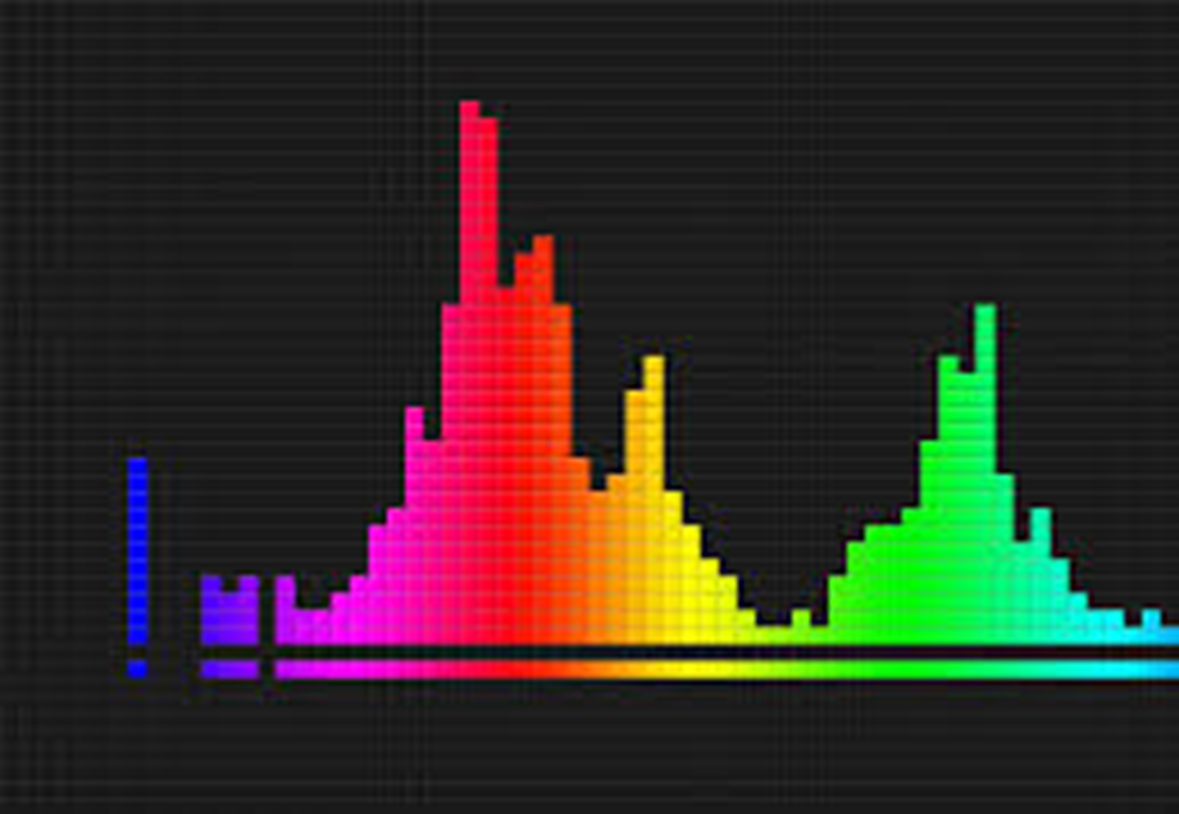

#### In this project we will peform EDA on the audio files using Librosa library and use Neural Networks to classify different audio files 

### Time Line of the project :
- Importing Libraries and Data set
- Data Analysis
- Model Building and Classification

Data set can be downloaded by this site : https://www.kaggle.com/chrisfilo/urbansound8k

In [ ]:
import pandas as pd 
import numpy as np
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import librosa
import librosa.display  #audio visualization

We have different audio files with different sounds. Our aim is to classify the correct lable for the sound

#### Reading Audio Files

In [ ]:
audio, sr= librosa.load('Urban Sound/fold2/100652-3-0-2.wav')
sound= ipd.Audio('Urban Sound/fold2/100652-3-0-2.wav')

In [ ]:
sound

In [ ]:
librosa.display.waveplot(audio)

#### Reading the comman file

In [ ]:
labels= pd.read_csv('Urban Sound/UrbanSound8K.csv')
labels

We have to create a model which will classify what category of sound the clip belongs to 

For this we will create independent features i.e. different time domain and frequency domain features and dependent labels that are present the the labels csv file.

We will extract the features for all the audio files 

#### Extracting Audio Features

1) Zero Crossing Rate : The is the rate at which a signal crosses the negative value to zero and then to a possitive value

In [ ]:
audio.shape

In [ ]:
FRAME_SIZE= 1024
HOP_LENGTH= 512
ZCR_music = librosa.feature.zero_crossing_rate(audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [ ]:
plt.plot(ZCR_music)

2) Mel Frequency Cepstral Coefficients : In sound processing, the mel-frequency cepstrum is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. Mel-frequency cepstral coefficients are coefficients that collectively make up an MFC.

In [ ]:
mfccs_music = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=10)
mfccs_music.shape

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs_music, 
                         x_axis="time", 
                         sr=sr)

Making a fucntion to extract these features :

In [ ]:
def mfcc_extractor(file_name):
    audio, sr= librosa.load(file_name)
    mfcc= librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=10)
    mfcc_scaled= np.mean(mfcc.T,axis=0)
    return mfcc_scaled

In [ ]:
def zcr_extractor(file_name):
    audio, sr= librosa.load(file_name)
    zcr= librosa.feature.zero_crossing_rate(audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    zcr_scaled= np.mean(zcr.T,axis=0)
    return zcr_scaled

Extracting from all the audio files

In [ ]:
labels

In [ ]:
import os
import tqdm
ind_features=[]
audio_dataset_path='Urban Sound'
for index_num,row in labels.iterrows():
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    label= row['class']
    #print(file_name)
    mfcc1= mfcc_extractor(file_name)
    #zcr= zcr_extractor(file_name)
    ind_features.append([mfcc1,label])

In [ ]:
import os
ind_features=[]
audio_dataset_path='Urban Sound'
for index_num,row in labels.iterrows():
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    label= row['class']
    #print(file_name)
    zcr1= zcr_extractor(file_name)
    ind_features.append([zcr1,label])

Now we will convert this into a data frame

In [ ]:
features_df= pd.DataFrame(ind_features,columns=['MFCCs','Labels'])
features_df.head()

Now we will split our independent and dependent features

In [ ]:
X=np.array(features_df['MFCCs'].tolist())  ## independent features
y=np.array(features_df['Labels'].tolist())  ## dependent features

Performing Label Encoding on the dependent features

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=to_categorical(le.fit_transform(y))

Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

#### Model Development

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
model=Sequential()
num_labels=y.shape[1]
###first layer
model.add(Dense(100,input_shape=(10,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('sigmoid'))
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
model.fit(X_train, y_train, batch_size= 10, epochs= 100, verbose=1)

In [ ]:
accuracy=model.evaluate(X_test,y_test,verbose=0)

In [ ]:
print("Accuracy of the model is :",accuracy)

In [ ]:
prediction= model.predict_classes(X_test)

In [ ]:
prediction

#### Testing on different audio files

In [ ]:
filename="Urban Sound/7064-6-0-0.wav"
audio, sample_rate = librosa.load(filename) 
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=10)
mfccs_mean = np.mean(mfccs.T,axis=0)


mfccs_mean=mfccs_mean.reshape(1,-1)
predicted_label=model.predict_classes(mfccs_mean)
print(predicted_label)
prediction_class = le.inverse_transform(predicted_label) 
prediction_class